In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from rep.estimators import TMVAClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import random
from copy import deepcopy
import cPickle as pickle



In [21]:
sample = 0.1

def load_data(track = 'long', 
              data_path = 'data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/',
              data_filename = 'data_train.csv', 
              
              sample=sample, seed = 0):
    
    
    
    #particle = particle[0].upper() + particle[1:].lower()
    track = track[0].upper() + track[1:].lower()
    
    cur_file_path = data_path + '/' + track + '/' + data_filename
    
    if sample:
        n = sum(1 for line in open(cur_file_path)) - 1
        s = int(n*sample)
        skip = sorted(random.sample(range(1,n+1),n-s))
    else:
        skip = None

    cur_data = pd.read_csv(cur_file_path, skiprows=skip)
    
    #data['TrackCloneDist'] *= 1 + 0.00001 * np.random.rand(len(data))
    
    
    return cur_data

def get_target(particle, loc_data, 
            code_dict = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}):
    
    particle = particle[0].upper() + particle[1:].lower()
    target = (np.abs(loc_data.MCParticleType.values) == code_dict[particle]) * 1
    return target

def load_features(particle, track='long',
                  config_path = 'data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/',
                  prefix = 'GlobalPID',
                  suffix = 'ANN.txt'):

    particle = particle[0].upper() + particle[1:].lower()
    track = track[0].upper() + track[1:].lower()
    cur_config_path = '_'.join([config_path + prefix, particle, track, suffix])
    cur_config = np.loadtxt(cur_config_path, dtype='S', delimiter='\n', comments='!')
    features = [item for item in cur_config[5:] if '#' not in item]
    return features 

def compare_rocs(particles, clfs, 
                 train, test, 
                 train_targets, test_targets, 
                 features,
                 dump = False,
                 dump_folder = 'models/',
                model_prefix = None,
                model_suffix = None):

    colors = plt.cm.rainbow(np.linspace(0,1,len(particles)))
    color_dict = {}
    for key, color in zip(particles, colors):
        color_dict[key] = color 
    plt.figure(figsize=(8,8))
    for key in particles:
        cur_clf = clfs[key]
        cur_train_target = train_targets[key]
        cur_test_target = test_targets[key]
        cur_features = features[key]

        cur_clf.fit(train[cur_features], cur_train_target)
        probs = cur_clf.predict_proba(test[cur_features])
        auc = roc_auc_score(cur_test_target, probs[:, 1])
        print(auc)
        fpr, tpr, _ = roc_curve(cur_test_target, probs[:, 1])
        #cur_results['ROC_curve'] = fpr, tpr
        plt.plot(fpr, tpr, color=color_dict[key], label = key + " AUC = %.3f" % auc)
        if dump:
            with open(dump_folder + model_prefix + '_' + key+'_classifier.pkl', 'wb') as f:
                pickle.dump(cur_clf, f)

    plt.legend(loc=4)
    plt.show()  
    
def get_models(loc_particles, 
              prefix, suffix = None, 
               model_folder = 'models/'):
    loc_clf_dict = dict.fromkeys(loc_particles)
    for key in loc_particles:
        with open(model_folder+ prefix + '_' + key+ suffix + '_classifier.pkl', 'rb') as f:
            loc_clf_dict[key] = pickle.load(f)
    return loc_clf_dict

def get_predictions(clfs, test, test_targets, features, color_dict = None,
                   title = 'ROC comparison for six reference particles'):
    if not color_dict:
        colors = plt.cm.rainbow(np.linspace(0,1,len(particles)))
        color_dict = {}
        for key, color in zip(particles, colors):
            color_dict[key] = color 
    plt.figure(figsize=(8,8))
    preds_df = pd.DataFrame(0, index = test.index, columns = particles)
    for key in particles:
        cur_clf = clfs[key]
        cur_test_target = test_targets[key]
        cur_features = features[key]
        cur_probs = cur_clf.predict_proba(test[cur_features])
        preds_df[key] = cur_probs
        auc = roc_auc_score(cur_test_target, cur_probs[:, 1])
        fpr, tpr, _ = roc_curve(cur_test_target, cur_probs[:, 1])
        plt.plot(fpr, tpr, color=color_dict[key], label = key + " AUC = %.3f" % auc)
    plt.legend(loc=4)
    plt.title(title, fontsize=20)
    plt.show()  
    return preds_df

In [22]:
particles = ['electron', 'pion', 'kaon', 'muon', 'ghost', 'proton']

test_data = pd.read_csv('sample_test.csv')
#test_data = load_data(data_filename='data_eval.csv')
features_dict = dict.fromkeys(particles)
train_target_dict = dict.fromkeys(particles)
test_target_dict = dict.fromkeys(particles)
mlp_dict = dict.fromkeys(particles)
bdt_dict = dict.fromkeys(particles)

true_df = pd.DataFrame(0, index = test_data.index, columns = particles)

for key in particles:
    features_dict[key] = load_features(key)  
    test_target_dict[key] = get_target(key, test_data)
    mlp_dict = get_models(particles, prefix = 'TMVA_kMLP', suffix = '_50_cycles')
    bdt_dict = get_models(particles, prefix = 'TMVA_kBDT', suffix = '_50_trees')
    true_df[key] = test_target_dict[key]

print('Done!')

Done!


In [23]:
for key in particles:
    print key, features_dict[key]

electron ['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability', 'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF', 'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 'MuonBkgLL', 'MuonMuLL', 'MuonIsMuon', 'MuonNShared', 'InAccMuon', 'MuonIsLooseMuon', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe']
pion ['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability', 'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF', 'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAbovePiThres', 'RichAboveKaThres', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 'MuonBkgLL', 'MuonMuLL', 'MuonIsMuon', 'MuonNShared', 'InAccMuon', 'MuonIsLooseMuon', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe']
kaon ['TrackP', 'T

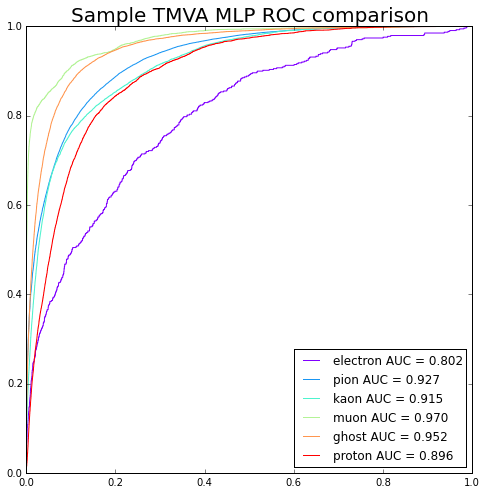

In [24]:
mlp_preds = get_predictions(mlp_dict, test_data, test_target_dict, features_dict, 
                title = 'Sample TMVA MLP ROC comparison')  

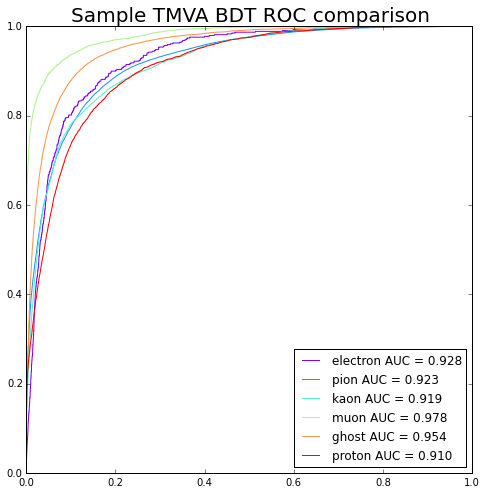

In [25]:
bdt_preds = get_predictions(bdt_dict, test_data, test_target_dict, features_dict, 
                title = 'Sample TMVA BDT ROC comparison')  

In [19]:
bdt_preds.head(10)

,electron,pion,kaon,muon,ghost,proton
0,0.688727,0.443921,0.530696,0.732172,0.704791,0.573810
1,0.712054,0.366146,0.605131,0.508540,0.654334,0.581092
2,0.652237,0.303716,0.903741,0.756088,0.470049,0.873414
3,0.764379,0.135845,0.870076,0.804590,0.852555,0.850816
4,0.677121,0.467165,0.644004,0.408405,0.413752,0.545261
5,0.805140,0.352949,0.567318,0.502225,0.853692,0.578529
6,0.865312,0.082333,0.763906,0.849720,0.909433,0.767155
7,0.599401,0.489394,0.636139,0.396110,0.445743,0.526732
8,0.267296,0.666690,0.530433,0.464311,0.333602,0.476840
9,0.566752,0.353408,0.619193,0.584718,0.788120,0.419144


In [26]:
mlp_preds.head(10)

,electron,pion,kaon,muon,ghost,proton
0,0.308173,0.182316,0.340134,0.454715,0.438226,0.235270
1,0.160249,0.161508,0.336221,0.369163,0.446132,0.339501
2,0.478636,0.006993,0.499758,0.449959,0.361200,0.498934
3,0.469114,0.006730,0.498330,0.461827,0.495653,0.496681
4,0.092925,0.349449,0.400337,0.212026,0.302972,0.468186
5,0.248180,0.054727,0.414487,0.253341,0.488322,0.367354
6,0.393509,0.010134,0.490768,0.479913,0.495312,0.477259
7,0.240619,0.350157,0.359093,0.159578,0.167625,0.278357
8,0.115583,0.269310,0.386319,0.389421,0.218579,0.334275
9,0.431581,0.229847,0.470558,0.498702,0.482649,0.070842


In [27]:
mlp_df = pd.DataFrame(0, index = particles, columns=particles)
for particle1 in particles:
    for particle2 in particles:
        if particle1 != particle2:
            inds = (true_df[particle1] == 1) | (true_df[particle2] == 1)
            cur_set = test_data[inds]
            cur_features = features_dict[particle1]
            cur_preds = mlp_dict[particle1].predict_proba(cur_set[cur_features])[:, 1]
            cur_auc = roc_auc_score(true_df.loc[inds, particle1], cur_preds)
            mlp_df.loc[particle1, particle2] = cur_auc

In [28]:
mlp_df

,electron,pion,kaon,muon,ghost,proton
electron,0.000000,0.808325,0.835311,0.912433,0.702559,0.833443
pion,0.805908,0.000000,0.914535,0.950830,0.938189,0.917808
kaon,0.797110,0.938662,0.000000,0.936372,0.933561,0.646919
muon,0.969876,0.969555,0.972779,0.000000,0.965874,0.975850
ghost,0.826256,0.951979,0.956392,0.968965,0.000000,0.950506
proton,0.832332,0.941507,0.561585,0.958837,0.922619,0.000000


/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


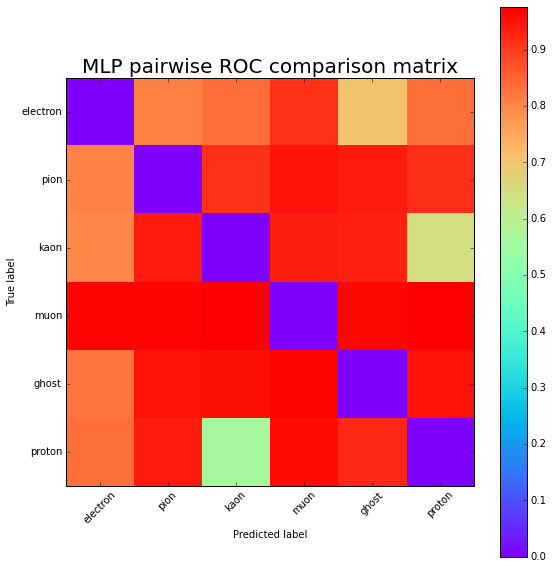

In [29]:

def plot_confusion_matrix(cm, title='Sample pairwise ROC comparison matrix', cmap=plt.cm.rainbow):
    #cm = (cm-cm.min())/(cm.max()-cm.min())
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = range(len(particles))
    plt.xticks(tick_marks, particles, rotation=45)
    plt.yticks(tick_marks, particles)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(mlp_df, title = 'MLP pairwise ROC comparison matrix')

plt.show()

In [30]:
bdt_df = pd.DataFrame(0, index = particles, columns=particles)
for particle1 in particles:
    for particle2 in particles:
        if particle1 != particle2:
            inds = (true_df[particle1] == 1) | (true_df[particle2] == 1)
            cur_set = test_data[inds]
            cur_features = features_dict[particle1]
            cur_preds = bdt_dict[particle1].predict_proba(cur_set[cur_features])[:, 1]
            cur_auc = roc_auc_score(true_df.loc[inds, particle1], cur_preds)
            bdt_df.loc[particle1, particle2] = cur_auc

In [31]:
bdt_df

,electron,pion,kaon,muon,ghost,proton
electron,0.000000,0.945801,0.923521,0.914866,0.865125,0.916700
pion,0.831083,0.000000,0.931808,0.896631,0.926853,0.925286
kaon,0.841422,0.942150,0.000000,0.937114,0.938094,0.646479
muon,0.975309,0.977881,0.982346,0.000000,0.975600,0.983167
ghost,0.854271,0.953835,0.956127,0.965766,0.000000,0.950912
proton,0.834293,0.943848,0.669529,0.948223,0.930154,0.000000


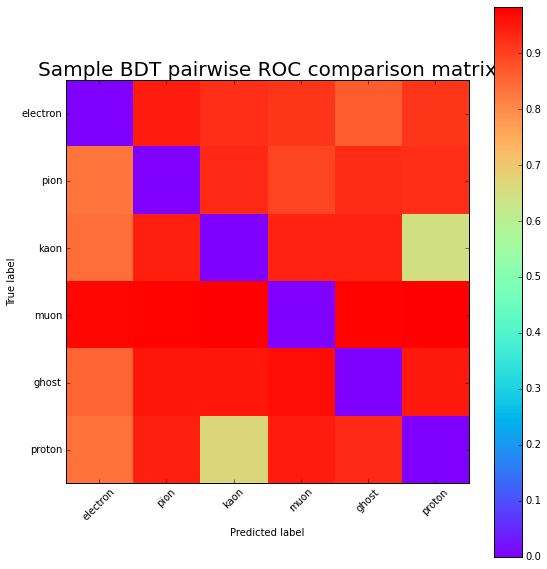

In [32]:
plot_confusion_matrix(bdt_df, title = 'Sample BDT pairwise ROC comparison matrix')

plt.show()

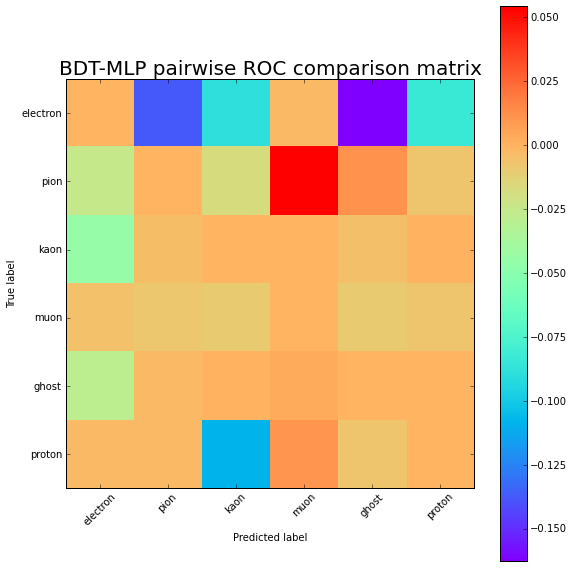

In [33]:
plot_confusion_matrix(mlp_df-bdt_df, title = 'BDT-MLP pairwise ROC comparison matrix')


### Cuts graphics

In [ ]:
n_cuts_mva = 80
n_cuts_dll = 150

n_bins = 100
n_bins_2d = 50

dll_min = {'Electron': -15., 'Muon': -15., 'Pion': -100., 'Kaon': -50., 'Proton': -50, 'Ghost': 0.}
dll_max = {'Electron': 15., 'Muon': 15., 'Pion': 100., 'Kaon': 50., 'Proton': 50, 'Ghost': 1.}
comb_dlls = {'Electron': "CombDLLe", 'Muon': "CombDLLmu", 'Pion': "CombDLLpi",
             'Kaon': "CombDLLk", 'Proton': "CombDLLp", 'Ghost': "TrackGhostProbability"}
particle_codes = {"Ghost": 0, "Electron": 11, "Muon": 13, "Pion": 211, "Kaon": 321, "Proton": 2212}

In [128]:
true_df.sum()/len(true_df)

electron    0.00503
pion        0.63924
kaon        0.10570
muon        0.04109
ghost       0.14294
proton      0.06552
dtype: float64